In [1]:
import math,random
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd.variable as Variable
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [3]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self,capacity):
        self.buffer=deque(maxlen=capacity)
    def push(self,state,action,reward,next_state,done):
        state=np.expand_dims(state,0)
        next_state=np.expand_dims(next_state,0)
        self.buffer.append((state,action,reward,next_state,done))
    def sample(self,batch_size):
        state,action,reward,next_state,done=zip(*random.sample(self.buffer,batch_size))
        return np.concatenate(state),action,reward,np.concatenate(next_state),done
    def __len__(self):
        return len(self.buffer)

In [4]:
env_id = "CartPole-v0"
env = gym.make(env_id)

c:\users\박정은\gym\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

In [8]:
class DuelingDQN(nn.Module):
    def __init__(self,num_inputs,num_actions):
        super(DuelingDQN,self).__init__()
        self.fc1=nn.Linear(num_inputs,128)
        self.ad1=nn.Linear(128,128)
        self.val1=nn.Linear(128,128)
        self.ad2=nn.Linear(128,num_actions)
        self.val2=nn.Linear(128,1)
    def forward(self,x):
        x=F.relu(self.fc1(x))
        advantage=F.relu(self.ad1(x))
        advantage=self.ad2(advantage)
        value=F.relu(self.val1(x))
        value=self.val2(value)
        return value+advantage-advantage.mean()
    def act(self,state,epsilon):
        if random.random()>epsilon:
            state=Variable(torch.FloatTensor(state).unsqueeze(0))
            q_value=self.forward(state)
            action=q_value.argmax().item()
        else:
            action=random.randrange(env.action_space.n)
        return action

In [9]:
current_model = DuelingDQN(env.observation_space.shape[0], env.action_space.n)
target_model  = DuelingDQN(env.observation_space.shape[0], env.action_space.n)

optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(1000)

In [10]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
update_target(current_model, target_model)

In [11]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = target_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - expected_q_value.detach()).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [12]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [14]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

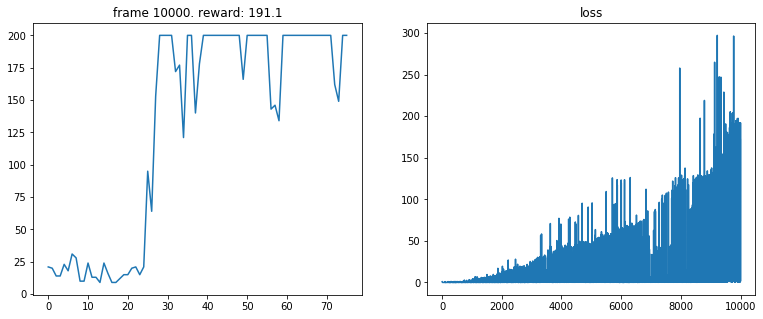

In [16]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 100 == 0:
        update_target(current_model, target_model)
        